In [8]:
#import modules
import pandas as pd
from xgboost import XGBRegressor
import sklearn
from sklearn.model_selection import train_test_split



#load data 
X = pd.read_csv("recs2015_public_v4.csv", index_col = "DOEID")
X.head()

#add new column to dataset based on US national energy prices as of July 2022.
def price_convertor(row):
    """calculates yearly energy cost in dollars"""
    current_cost = row * 0.166 #multiplies kilowatthours used between 01/01/2015-31/12/2015 by US energy prices in July 2022
    return current_cost

X["2022_price"] = X["KWH"].apply(price_convertor)



In [9]:

#check if any rows are missing target data. Other columns assessed later to avoid data leakage.  
missing_target = X["KWH"].isnull().sum()
print(missing_target) #no issue -> therefore no need to remove any

#seperate predictor & outcome variables
y= X["2022_price"]
X.drop(["2022_price"], axis = 1, inplace = True)

#setup training & test data 
from sklearn.model_selection import train_test_split
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0)

0


The dataset had already been imputed, therefore this step was skipped in the present program. Two coulmns containing categorical variables were dropped as they referred to survey procedures. An earlier model tried to incoporate these factors, but it introduced a substantial degree of error into the model. There were no other categorical columns. 

Additionally, several columns were excluded as they were different measurements of the outcome variable used by the model (total annual killowatt hours). For example, one excluded variable was: "Electricity usage for space heating, main and secondary, in kilowatthours, 2015". 

In [10]:
#drop  columns refering to survey procedures (both contained categorical values) 
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ["int64", "float64"]]
X_train_temp = X_train_full[numeric_cols].copy()
X_valid_temp = X_valid_full[numeric_cols].copy()

#select variables of interest. 
X_train = X_train_temp.loc[:,"REGIONC":"TOTSQFT_EN"]
X_valid = X_valid_temp.loc[:,"REGIONC":"TOTSQFT_EN"]



In [11]:
# #preprocessing for categorical data
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# categorical_transformer = Pipeline(steps = [
#     ("imputer", SimpleImputer(strategy = "most_frequent")),
#     ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# preprocessor = ColumnTransformer(transformers = [("cat", categorical_transformer, object_cols)])


# Original Model 
Uses full set of variables to predict energy usage

In [12]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import sklearn

#N_VALUES = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
LEARNING_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
MAE_list =[]
MAPE_list = []
for l in LEARNING_VALUES:
    #fit model
    model = XGBRegressor(n_estimators = 400, early_stopping_rounds = 5, learning_rate = l)
    model.fit(X_train, y_train, eval_set= [(X_train, y_train)])
    #make predictions 
    predictions = model.predict(X_valid)

    #calculate mean absolute error for each model
    mae = mean_absolute_error(predictions, y_valid)
    MAE_list.append(mae)

    #calculate mean absolute percentage error for each model 
    mape = sklearn.metrics.mean_absolute_percentage_error(y_true = y_valid, y_pred = predictions )
    MAPE_list.append(mape)

[0]	validation_0-rmse:1989.99558
[1]	validation_0-rmse:1825.88371
[2]	validation_0-rmse:1678.55827
[3]	validation_0-rmse:1547.67361
[4]	validation_0-rmse:1431.08154
[5]	validation_0-rmse:1327.23287
[6]	validation_0-rmse:1233.49263
[7]	validation_0-rmse:1151.11515
[8]	validation_0-rmse:1077.32367
[9]	validation_0-rmse:1010.71661
[10]	validation_0-rmse:952.19405
[11]	validation_0-rmse:900.29263
[12]	validation_0-rmse:855.32779
[13]	validation_0-rmse:814.61550
[14]	validation_0-rmse:779.05664
[15]	validation_0-rmse:746.40204
[16]	validation_0-rmse:717.25545
[17]	validation_0-rmse:691.59024
[18]	validation_0-rmse:668.01498
[19]	validation_0-rmse:648.11774
[20]	validation_0-rmse:631.22370
[21]	validation_0-rmse:615.49058
[22]	validation_0-rmse:601.31806
[23]	validation_0-rmse:587.97702
[24]	validation_0-rmse:576.08312
[25]	validation_0-rmse:564.20506
[26]	validation_0-rmse:553.84135
[27]	validation_0-rmse:544.96205
[28]	validation_0-rmse:537.24669
[29]	validation_0-rmse:529.74033
[30]	valid

In [13]:
#assess which model parameters most effective 
print(MAPE_list)

#make model consisting of best model's parameters 
model = XGBRegressor(n_estimators = 400, early_stopping_rounds = 5, learning_rate = 0.1)
model.fit(X_train, y_train, eval_set= [(X_train, y_train)])
predictions = model.predict(X_valid)

[0.36402568794344053, 0.3790477781960693, 0.38909322853639133, 0.39783573296191876, 0.4311261361422698, 0.44060208303620013, 0.46124761328325586, 0.5196326067027458, 0.5250723040064831]
[0]	validation_0-rmse:1989.99558
[1]	validation_0-rmse:1825.88371
[2]	validation_0-rmse:1678.55827
[3]	validation_0-rmse:1547.67361
[4]	validation_0-rmse:1431.08154
[5]	validation_0-rmse:1327.23287
[6]	validation_0-rmse:1233.49263
[7]	validation_0-rmse:1151.11515
[8]	validation_0-rmse:1077.32367
[9]	validation_0-rmse:1010.71661
[10]	validation_0-rmse:952.19405
[11]	validation_0-rmse:900.29263
[12]	validation_0-rmse:855.32779
[13]	validation_0-rmse:814.61550
[14]	validation_0-rmse:779.05664
[15]	validation_0-rmse:746.40204
[16]	validation_0-rmse:717.25545
[17]	validation_0-rmse:691.59024
[18]	validation_0-rmse:668.01498
[19]	validation_0-rmse:648.11774
[20]	validation_0-rmse:631.22370
[21]	validation_0-rmse:615.49058
[22]	validation_0-rmse:601.31806
[23]	validation_0-rmse:587.97702
[24]	validation_0-rmse

# Top 30 model 
Uses only the 30 most important features to reduce processing time. Comes at relatively small decrease in model accuracy. 



The original model uses an infeasibly high number of features. Not only does this mean the model is impractical for any real-world applications, but it may also reduce the model's accuracy. 


Matplotlib is building the font cache; this may take a moment.


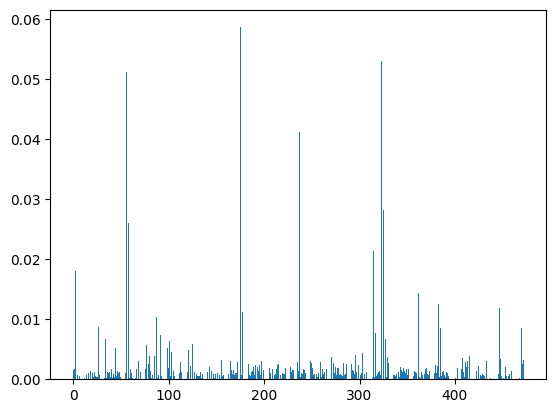

['DRYRFUEL', 'ELWATER', 'MORETHAN1H2O', 'SWIMPOOL', 'FUELHEAT', 'FUELH2O2', 'MONPOOL', 'FUELH2O', 'TYPEHUQ', 'ZUSEWWAC', 'TVCOLOR', 'NGPAY', 'NHSLDMEM', 'UGWATER', 'DRYRUSE', 'SIZRFRI2', 'ELWARM', 'BEDROOMS', 'NCOMBATH', 'TOTCSQFT', 'NUMADULT', 'H2OHEATAPT', 'AGERFRI2', 'TOTROOMS', 'LGTINNUM', 'AGEFRZR', 'NUMFREEZ', 'SEPOVENUSE', 'NUMFRIG', 'WINDOWS']
       DRYRFUEL  ELWATER  MORETHAN1H2O  SWIMPOOL  FUELHEAT  FUELH2O2  MONPOOL  \
DOEID                                                                           
10001         5        0             0         0         1        -2       -2   
10002        -2        1             0         0         5        -2       -2   
10003         5        0             0         0         1        -2       -2   
10004         5        0             0         0         2        -2       -2   
10005         5        0             0         0         1        -2       -2   
...         ...      ...           ...       ...       ...       ...      ...  

In [14]:
from matplotlib import pyplot

#get importance of each predictor from model 
importance = model.feature_importances_

#visualise importance 
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#turn model's importance attribute into a dictionary  
importance_dict = {}
for i, v in enumerate(importance):
    importance_dict[i] = v

#get top 30 most important features 
sort = sorted(importance_dict, key=importance_dict.get, reverse=True)
top_30 = [str(X_train.columns[i]) for i in sort[:30]]

print(top_30)


#get column name for each index position 
X_copy = X.copy()
X_top_30 = X_copy.loc[:,top_30]
print(X_top_30)


In [15]:
#create training & test data of top-30 columns 
X_train_T30, X_valid_T30, y_train_T30, y_valid_T30 = train_test_split(X_top_30,y, train_size = 0.8, test_size = 0.2, random_state = 0)

#N_VALUES = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
LEARNING_VALUES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
MAE_list =[]
MAPE_list = []
for l in LEARNING_VALUES:
    #fit model
    model = XGBRegressor(n_estimators = 400, early_stopping_rounds = 5, learning_rate = l)
    model.fit(X_train_T30, y_train_T30, eval_set= [(X_train_T30, y_train_T30)])
    #make predictions 
    predictions = model.predict(X_valid_T30)

    #calculate mean absolute error for each model
    mae = mean_absolute_error(predictions, y_valid)
    MAE_list.append(mae)

    #calculate mean absolute percentage error for each model 
    mape = sklearn.metrics.mean_absolute_percentage_error(y_true = y_valid, y_pred = predictions )
    MAPE_list.append(mape)

print(f"MAE: {MAE_list}")
print(f"MAPE: {MAPE_list}")

[0]	validation_0-rmse:1990.68189
[1]	validation_0-rmse:1827.03941
[2]	validation_0-rmse:1680.64131
[3]	validation_0-rmse:1551.45472
[4]	validation_0-rmse:1435.93062
[5]	validation_0-rmse:1333.81483
[6]	validation_0-rmse:1242.51734
[7]	validation_0-rmse:1161.73976
[8]	validation_0-rmse:1089.87379
[9]	validation_0-rmse:1026.56929
[10]	validation_0-rmse:970.43977
[11]	validation_0-rmse:922.48704
[12]	validation_0-rmse:878.98313
[13]	validation_0-rmse:841.65295
[14]	validation_0-rmse:808.29422
[15]	validation_0-rmse:779.38511
[16]	validation_0-rmse:754.72564
[17]	validation_0-rmse:732.70859
[18]	validation_0-rmse:712.62600
[19]	validation_0-rmse:696.05851
[20]	validation_0-rmse:681.58539
[21]	validation_0-rmse:668.99010
[22]	validation_0-rmse:657.13246
[23]	validation_0-rmse:646.69094
[24]	validation_0-rmse:637.64666
[25]	validation_0-rmse:629.98176
[26]	validation_0-rmse:623.35179
[27]	validation_0-rmse:617.27966
[28]	validation_0-rmse:611.23647
[29]	validation_0-rmse:605.51192
[30]	valid